In [28]:
# import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import joblib

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# load dataset
df = pd.read_csv('dataset/news.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


In [30]:
df.tail(5)

,title,text,subject,date,class
44914,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
44915,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
44916,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
44917,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
44918,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [31]:
df.sample(5)

,title,text,subject,date,class
13214,OBAMA FLASHBACK: Hear What Obama Said About Ta...,You probably guessed it..he gave a line of tot...,politics,"Aug 19, 2016",0
39616,Britain's May 'deeply concerned' over reports ...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"October 30, 2017",1
6930,Major Corporation Leaves South Carolina After...,South Carolina Republicans just introduced an ...,News,"April 13, 2016",0
22354,REVEALED: How US Government-Media Complex Are ...,Washingtons BlogEveryone s talking about fak...,US_News,"November 27, 2016",0
43572,Three more cars torched in South African taxi war,JOHANNESBURG (Reuters) - A violent feud betwee...,worldnews,"September 14, 2017",1


In [32]:
df.shape

(44919, 5)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44919 entries, 0 to 44918
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44919 non-null  object
 1   text     44919 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44919 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [34]:
df.describe()

,class
count,44919.000000
mean,0.476792
std,0.499467
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [35]:
df.isnull().sum()   

title       0
text        0
subject    21
date       21
class       0
dtype: int64

In [36]:
df.duplicated().sum()


np.int64(229)

#### Dropping the title, subject and date column as these are not helpful for news identification.

In [37]:
df.drop(['title', 'subject','date'], axis=1, inplace=True)
df.head(5)

,text,class
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [38]:
df.text.nunique()

38657

In [39]:
df['class'].unique()

array([0, 1])

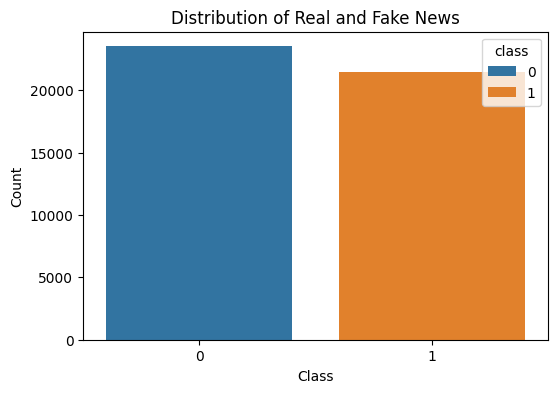

In [40]:
# visualize the distribution of classes
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=df, hue='class')
plt.title('Distribution of Real and Fake News')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

#### Shuffling the dataset to prevent the model to get bias. Also reset the index and then drop it as index column is not useful.

In [41]:
df = df.sample(frac=1)
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head(5)

,text,class
0,WASHINGTON (Reuters) - U.S. Senate Democratic ...,1
1,"#JokeNewsAfter record, cold temperatures were ...",0
2,(Reuters) - The National Wrestling Hall of Fam...,1
3,21st Century Wire says In typical NDAA signing...,0
4,"Last night, The New York Times ran a story tha...",0


# Preprocessing and analysis of News column
Removing all the stopwords, punctuations and any irrelevant spaces from the text.

In [42]:
# Function to preprocess text
def preprocess_text(text_data):
    preprocessed_text = []
    stop_words = set(stopwords.words('english'))

    for sentence in tqdm(text_data):
        # Remove punctuation
        sentence = re.sub(r'[^\w\s]', '', str(sentence))
        # Lowercase + remove stopwords
        cleaned_sentence = ' '.join(
            token.lower()
            for token in sentence.split()
            if token.lower() not in stop_words
        )
        preprocessed_text.append(cleaned_sentence)

    return preprocessed_text

preprocessed_rev = preprocess_text(df['text'].values)
df['text'] = preprocessed_rev
df.head(5) 

100%|██████████| 44919/44919 [00:05<00:00, 8799.72it/s]


,text,class
0,washington reuters us senate democratic leader...,1
1,jokenewsafter record cold temperatures reporte...,0
2,reuters national wrestling hall fame monday re...,1
3,21st century wire says typical ndaa signing fa...,0
4,last night new york times ran story potential ...,0


# Lets visualize real & fake news using wordcloud

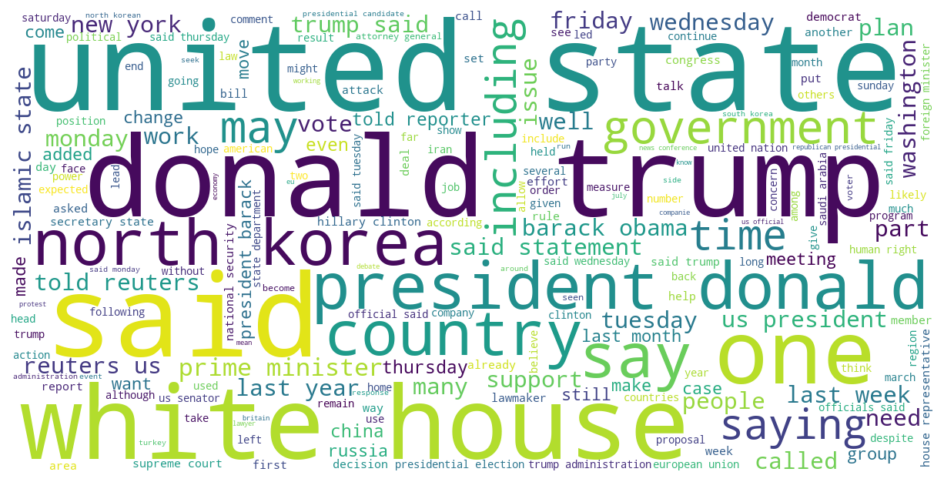

In [43]:
# real news
consol_r = ''.join(
    word for word in df['text'][df['class']==1].astype(str)
)
wordcloud = WordCloud(background_color='white', width=1200, height=600).generate(consol_r)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

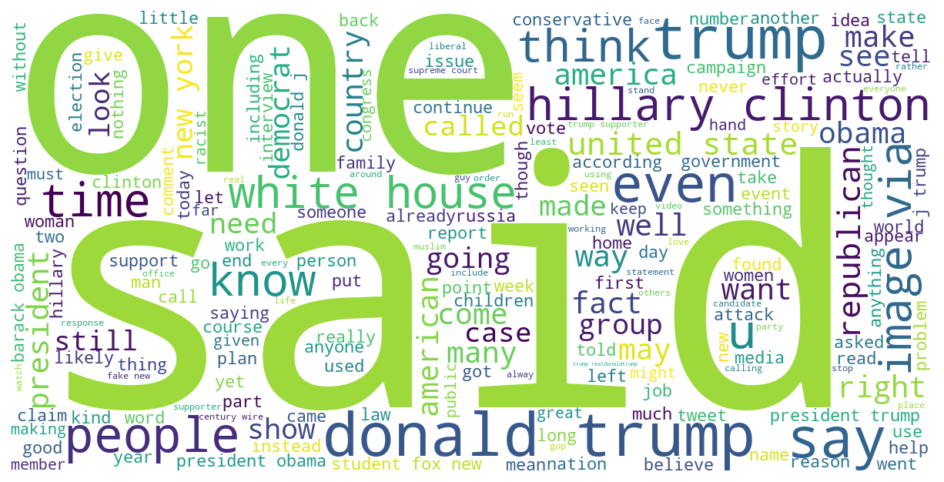

In [44]:
# fake news 
consol_f = ''.join(
    word for word in df['text'][df['class']==0].astype(str)
)
wordcloud = WordCloud(background_color='white', width=1200, height=600).generate(consol_f)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Let's plot the bargraph of the top 20 most frequent words.

<Axes: title={'center': 'Bar Chart of Top Words Frequency'}, xlabel='Top Words', ylabel='Count'>

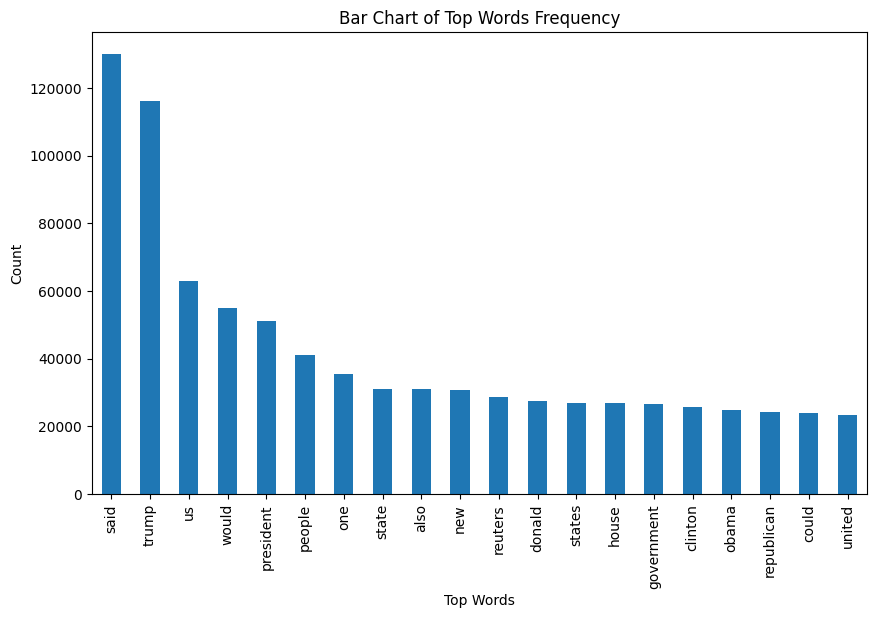

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1],
                        reverse=True)
    return words_freq[:n]


common_words = get_top_words(df['text'], 20)
df1 = pd.DataFrame(common_words, columns=['Review', 'count'])
df1_asc = df1.groupby('Review').sum()['count'].sort_values(ascending=False)

df1_asc.plot(
    kind='bar',
    figsize=(10, 6),
    xlabel="Top Words",
    ylabel="Count",
    title="Bar Chart of Top Words Frequency"
    )

# Splitting dataset into train and test sets

In [46]:
x= df['text']
y= df['class']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25)


In [47]:
# Converting text into vectors
vector = TfidfVectorizer()
x_train = vector.fit_transform(x_train)
x_test = vector.transform(x_test)



In [48]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(x_train,y_train)
y_pred_lr = lr.predict(x_test)
accuracy = accuracy_score(y_test,y_pred_lr)
print("Logistic Regression Accuracy:", accuracy)

Logistic Regression Accuracy: 0.9892252894033838


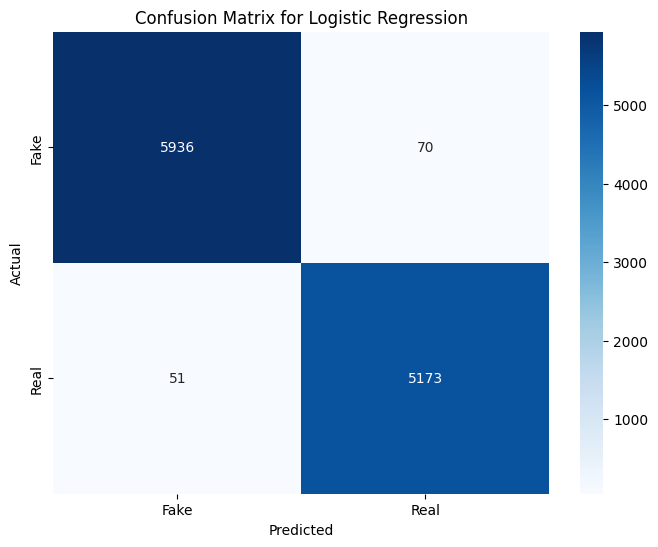

In [49]:
# Confusion Matrix
conf_mat_lr = metrics.confusion_matrix(y_test,y_pred_lr)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_lr, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()


In [50]:
# Decision Tree Classifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)
y_pred_dtc = dtc.predict(x_test)
accuracy = accuracy_score(y_test,y_pred_dtc)
print("Decision Tree Classifier Accuracy:", accuracy)

Decision Tree Classifier Accuracy: 0.9953695458593055


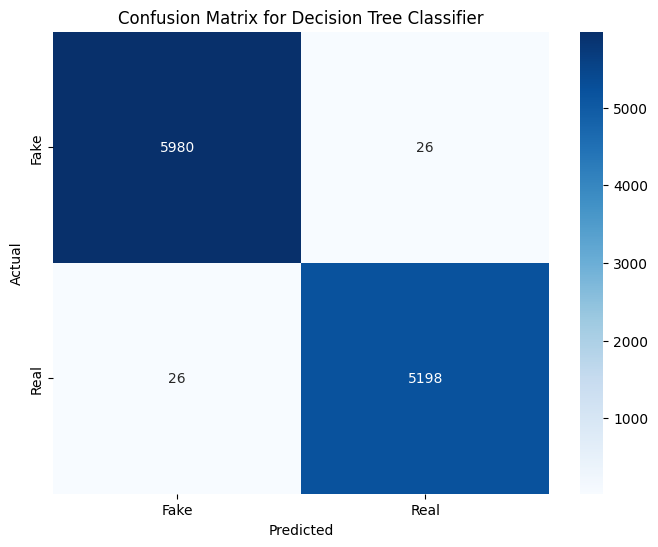

In [51]:
# Confusion Matrix
conf_mat_dtc = metrics.confusion_matrix(y_test,y_pred_dtc)
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat_dtc, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake', 'Real'],
            yticklabels=['Fake', 'Real'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()


# Sving the cleaned dataset

In [52]:
df.to_csv('dataset/cleaned_dataset.csv', index=False)

# Saving the trained models

In [53]:
joblib.dump(vector, "trained_models/tfidf_vectorizer.pkl")
joblib.dump(lr, "trained_models/Logistic Regression.pkl")
joblib.dump(dtc, "trained_models/Decision Tree Classifier.pkl")

['trained_models/Decision Tree Classifier.pkl']

# conclusion:
- Logistic Regression and Decision Tree Classifier both perfomed well.
- But Decision Tree Classifier slightly out performed Logistic Regression and achieved 99% accuracy while 
  Logistic Regression got 98% accuracy.